# **CIS 520: Machine Learning**

## **Categorical Features**


- **Content Creator:** Siyun Hu
- **Content Reviewers:** Zhangkaiwen Chu, Parth Sheth
- **References:**
  - [Wiki of Categorical Variable](https://en.wikipedia.org/wiki/Categorical_variable)
  - [Github Repo](https://github.com/Yimeng-Zhang/feature-engineering-and-feature-selection)
  - [Kaggle](https://www.kaggle.com/shree1992/housedata)
- **Objectives:** The objectives of this worksheets are:
  - Understand the concept of categorical features
  - Understand two encoding methods: one-hot encoding and mean encoding
  - Compare the differences between encoding methods



# Initialize Penn Grader

In [1]:
%%capture
!pip install penngrader

In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os 

In [3]:
# For autograder only, do not modify this cell. 
# True for Google Colab, False for autograder
NOTEBOOK = (os.getenv('IS_AUTOGRADER') is None)
if NOTEBOOK:
    print("[INFO, OK] Google Colab.")
else:
    print("[INFO, OK] Autograder.")
    sys.exit()

[INFO, OK] Google Colab.


In [4]:
#PLEASE ENSURE YOUR PENN-ID IS ENTERED CORRECTLY. IF NOT, THE AUTOGRADER WON'T KNOW WHO 
#TO ASSIGN POINTS TO YOU IN OUR BACKEND
STUDENT_ID = 57931095 # YOUR PENN-ID GOES HERE AS AN INTEGER#

In [5]:
import penngrader.grader

grader = penngrader.grader.PennGrader(homework_id = 'CIS_5200_202230_HW_Categorical_Features_WS', student_id = STUDENT_ID)

PennGrader initialized with Student ID: 57931095

Make sure this correct or we will not be able to store your grade


In [6]:
# A helper function for grading utils
def grader_serialize(obj):        # A helper function
    '''Dill serializes Python object into a UTF-8 string'''
    byte_serialized = dill.dumps(obj, recurse = True)
    return base64.b64encode(byte_serialized).decode("utf-8")

# Imports

In [7]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import seaborn as sns

## **Introduction**

A **categorical variable** is a variable that can take on one of a limited, and usually fixed, number of possible values, assigning each individual to a particular group or nominal category on the basis of some qualitative property.

We can further divide categorical data into two subtypes:

- **Nominal variable**: no natural order exists, such as gender
- **Ordinal variable**: categories can be meaningfully order, such as size of clothes

Usually, we cannot directly use categorical features in the model. We must transform them into numbers so that algorithms can handle those values. You might notice that some algorithm can directly take categorical input. It is most likely that the algorithm incorporate the encoding process within.

In the following notebook, we use a case to help you understand how we deal with categorical features confronting with real-world problem. 

## **Data Preparation**

In this notebook, we use the dataset from [Kaggle](https://www.kaggle.com/shree1992/housedata). You can download the data.csv using the above link and upload it to Colab. 

This dataset contains both numerical and categorical features. With the help of these features, we can try to predict the house price.

In [9]:
# import data
## specify the type of input data
type_dict = {'waterfront':'object','view':'object','condition':'object'}
## Note that you should change the path if you store the file under other directory
data = pd.read_csv('/content/sample_data/data.csv',dtype=type_dict)

In [10]:
data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


In [11]:
# show the statistics of all categorical features
data.describe(include="object")

,date,waterfront,view,condition,street,city,statezip,country
count,4600,4600,4600,4600,4600,4600,4600,4600
unique,70,2,5,5,4525,44,77,1
top,2014-06-23 00:00:00,0,0,3,2520 Mulberry Walk NE,Seattle,WA 98103,USA
freq,142,4567,4140,2875,4,1573,148,4600


Below we do some simple feature engineering work. You can manipulate the features based on your understanding towards this task.

In [12]:
# feature engineering

## Step 1: transfer yr_built into age
data['age'] = data['yr_built'].apply(lambda x: 2021-x)

## Step 2: divide statezip into state and zip
data['state'] = data['statezip'].apply(lambda x: x[:2])
data['zipcode'] = data['statezip'].apply(lambda x: x[3:])

## Step 3: transfer yr_renovated into if_renovated - whether the house has been renovated or not
data['if_renovated'] = data['yr_renovated'].apply(lambda x: 1 if x!=0 else 0)

## Step 4: standardize sqft_living, sqft_above, sqft_basement and sqft_lot
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
scaled_num = scaler.fit_transform(data[['sqft_living','sqft_lot','sqft_above','sqft_basement']])

## Step 5: drop irrelevant features
data = data.drop(['country','sqft_living','sqft_lot','sqft_above','sqft_basement','yr_built','yr_renovated','street','statezip'], axis = 1)

## Step 6: concatenate the categorical feature and standardize numerical features
num_df = pd.DataFrame(scaled_num, columns=['sqft_living','sqft_lot','sqft_above','sqft_basement'])
final_df = pd.concat([data, num_df], axis = 1)

## Step 7: drop rows with zero price
final_df = final_df[final_df['price']!=0]

After feature engineering, we can see the summary of features again.

In [13]:
final_df.describe()

,price,bedrooms,bathrooms,floors,age,if_renovated,sqft_living,sqft_lot,sqft_above,sqft_basement
count,4.551000e+03,4551.000000,4551.000000,4551.000000,4551.000000,4551.000000,4551.000000,4551.000000,4551.000000,4551.000000
mean,5.579059e+05,3.394639,2.155021,1.512195,50.204351,0.405405,-0.007242,-0.000480,-0.005851,-0.004161
std,5.639299e+05,0.904595,0.776351,0.538531,29.760073,0.491024,0.992573,1.002328,0.991158,0.995477
min,7.800000e+03,0.000000,0.000000,1.000000,7.000000,0.000000,-1.837133,-0.396162,-1.690416,-0.672464
25%,3.262643e+05,3.000000,1.750000,1.000000,24.000000,0.000000,-0.705374,-0.274592,-0.739223,-0.672464
50%,4.650000e+05,3.000000,2.250000,1.500000,45.000000,0.000000,-0.175835,-0.199900,-0.275226,-0.672464
75%,6.575000e+05,4.000000,2.500000,2.000000,70.000000,1.000000,0.488684,-0.107984,0.548368,0.620398
max,2.659000e+07,9.000000,8.000000,3.500000,121.000000,1.000000,11.837428,29.524796,8.795908,9.713525


Note that after feature engineering, `if_renovated` becomes categorical feature, too. However, since it is binary variable, it is not necessary to perform any transformation on it.

In [14]:
final_df.describe(include="object")

,date,waterfront,view,condition,city,state,zipcode
count,4551,4551,4551,4551,4551,4551,4551
unique,70,2,5,5,44,1,77
top,2014-06-23 00:00:00,0,0,3,Seattle,WA,98103
freq,141,4521,4103,2851,1561,4551,148


## *Question 1*

Observe the above table, what do you find about the remaining categorical features? 
Think about whether it is necessary for us to include all of them in our model.

We choose to drop a few of the features

In [15]:
states_to_drop = ['city','date','state']
final_df = final_df.drop(states_to_drop, axis = 1)

Below is all categorical features we finally choose to keep. 

In [16]:
cat_columns = [col for col in final_df.columns if final_df[col].dtype=='object']
cat_columns

['waterfront', 'view', 'condition', 'zipcode']

Next, we draw the histogram of all categorical features. 

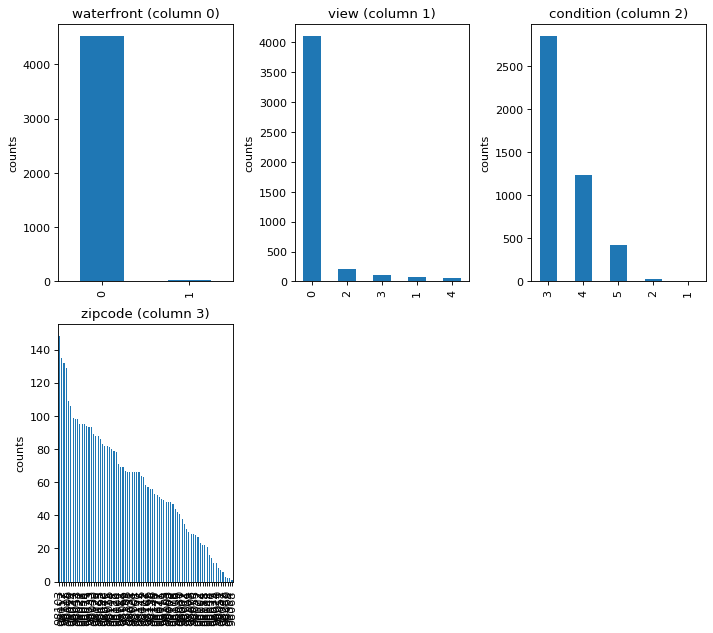

In [17]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (3 * nGraphPerRow, 4 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

plotPerColumnDistribution(final_df[cat_columns],6,3)

## *Question 2*

By observing the histogram and summary table of categorical features, you must notice that `zipcode` has the highest cardinality among all categorical features. What problems might such high cardinality cause in the training process? How can we handle them? 

*Hint: the number of labels within a categorical variable is known as cardinality.*

Moreover, by running the following cell, we generate our training and test data set. Note that we operate log tranformation on the dependent variable - `price`. Why shall we do this?

In [18]:
from sklearn.model_selection import train_test_split

y = np.log(final_df['price'])
X = final_df.drop('price', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [19]:
# Question 1: Describe the possible problems caused by high cardinality.
ans1 = "skewedness of data"
# Question 2: Describe reason for log transformation.
ans2 = "lower scale disparity"

In [20]:
grader.grade(test_case_id='test_desc', answer=[ans1,ans2])

Correct! You earned 2.0/2.0 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## **Feature Encoding**

In this part, we mainly introduce two encoding methods:

- One-hot encoding
- Mean encoding

By comparing the model performance on the test set, we can understand distinctions between various encoding methods.

### One-hot encoding

First of all, we try to use **One-hot encoding**. It means that we replace the categorical variable by different boolean variables to indicate whether or not certain label is true for that observation.

In [21]:
X_train.describe(include="object")

,waterfront,view,condition,zipcode
count,3185,3185,3185,3185
unique,2,5,5,77
top,0,0,3,98103
freq,3166,2878,1977,105


In [22]:
X_test.describe(include="object")

,waterfront,view,condition,zipcode
count,1366,1366,1366,1366
unique,2,5,5,73
top,0,0,3,98103
freq,1355,1225,874,43


Observe the above two tables, what do you find? What's the difference betweent the training and test dataset? And how can we solve this problem?



In [23]:
miss_zip = [zip for zip in X_train['zipcode'].unique() if zip not in X_test['zipcode'].unique()]
miss_zip

['98068', '98039', '98354', '98288']

In [24]:
X[X['zipcode'].isin(miss_zip)].groupby('zipcode').count().reset_index()

,zipcode,bedrooms,bathrooms,floors,waterfront,view,condition,age,if_renovated,sqft_living,sqft_lot,sqft_above,sqft_basement
0,98039,11,11,11,11,11,11,11,11,11,11,11,11
1,98068,1,1,1,1,1,1,1,1,1,1,1,1
2,98288,3,3,3,3,3,3,3,3,3,3,3,3
3,98354,2,2,2,2,2,2,2,2,2,2,2,2


Now, we can clearly see that there are four zipcodes, which exists in the training set but not in the test set. Our solution is simply set the non-existent zipcode to 0 in the test set. 

In [25]:
from sklearn.preprocessing import OneHotEncoder

onehot_enc = OneHotEncoder(drop='first')
# fit the encoder with X_train
onehot_enc = onehot_enc.fit(X_train[cat_columns])

In [26]:
out_feature_names = onehot_enc.get_feature_names(cat_columns)
out_feature_names

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array(['waterfront_1', 'view_1', 'view_2', 'view_3', 'view_4',
       'condition_2', 'condition_3', 'condition_4', 'condition_5',
       'zipcode_98002', 'zipcode_98003', 'zipcode_98004', 'zipcode_98005',
       'zipcode_98006', 'zipcode_98007', 'zipcode_98008', 'zipcode_98010',
       'zipcode_98011', 'zipcode_98014', 'zipcode_98019', 'zipcode_98022',
       'zipcode_98023', 'zipcode_98024', 'zipcode_98027', 'zipcode_98028',
       'zipcode_98029', 'zipcode_98030', 'zipcode_98031', 'zipcode_98032',
       'zipcode_98033', 'zipcode_98034', 'zipcode_98038', 'zipcode_98039',
       'zipcode_98040', 'zipcode_98042', 'zipcode_98045', 'zipcode_98047',
       'zipcode_98050', 'zipcode_98051', 'zipcode_98052', 'zipcode_98053',
       'zipcode_98055', 'zipcode_98056', 'zipcode_98057', 'zipcode_98058',
       'zipcode_98059', 'zipcode_98065', 'zipcode_98068', 'zipcode_98070',
       'zipcode_98072', 'zipcode_98074', 'zipcode_98075', 'zipcode_98077',
       'zipcode_98092', 'zipcode_98102', 'zip

In [27]:
onehot_output = pd.DataFrame(onehot_enc.transform(X_train[cat_columns]).toarray(),columns=out_feature_names)

# concatenate the output of one-hot encoding and the numerical features
num_columns = [col for col in X_train.columns if col not in cat_columns]
X_train_onehot = pd.concat([X_train[num_columns].reset_index(),onehot_output], axis=1)
X_train_onehot = X_train_onehot.drop('index', axis =1)
X_train_onehot.head()

,bedrooms,bathrooms,floors,age,if_renovated,sqft_living,sqft_lot,sqft_above,sqft_basement,waterfront_1,...,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,zipcode_98288,zipcode_98354
0,2.0,1.00,1.0,70,1,-1.141464,-0.259905,-0.913221,-0.672464,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.0,2.50,1.5,112,1,0.021444,-0.330333,-0.658023,1.266829,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,1.75,1.0,38,0,-0.964952,-0.188891,-0.716023,-0.672464,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,3.00,1.0,45,1,0.353704,0.848635,-0.240426,1.180638,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,2.75,2.0,23,1,-0.040854,-0.125152,-0.368025,0.598850,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Transform X_test using the same encoder

In [28]:
onehot_output_test = pd.DataFrame(onehot_enc.transform(X_test[cat_columns]).toarray(),columns=out_feature_names)
X_test_onehot = pd.concat([X_test[num_columns].reset_index(),onehot_output_test], axis=1)
X_test_onehot = X_test_onehot.drop('index', axis =1)
X_test_onehot.head()

,bedrooms,bathrooms,floors,age,if_renovated,sqft_living,sqft_lot,sqft_above,sqft_basement,waterfront_1,...,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,zipcode_98288,zipcode_98354
0,4.0,4.50,1.0,20,0,3.406339,2.426872,2.392755,2.624334,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,1.00,1.0,98,0,-0.165452,-0.274592,-0.855222,1.245281,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,2.50,2.0,30,0,0.613282,-0.072226,1.047164,-0.672464,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,1.00,1.0,62,0,-1.162231,-0.173981,-0.936421,-0.672464,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,1.75,1.0,44,0,0.166808,-0.087861,0.153971,0.060158,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now, we ensure that the columns in the `X_train_onehot` and `X_test_onehot` are the same. Then, we can start the training and test process.

In [29]:
X_train_onehot.columns.equals( X_test_onehot.columns)

True

In [30]:
from sklearn.metrics import mean_squared_error

def pipeline(X_train, X_test, y_train, y_test, model):
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    print('-----------------------')
    print(model)
    print('Mean Squared Error: ' + str(mse))
    print('Mean Absolute Percentage Error: '+str(mape))

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(max_depth=5, random_state=0)
lr = LinearRegression()

pipeline(X_train_onehot, X_test_onehot, y_train, y_test, rfr)
pipeline(X_train_onehot, X_test_onehot, y_train, y_test, lr)

-----------------------
RandomForestRegressor(max_depth=5, random_state=0)
Mean Squared Error: 0.1251716037430666
Mean Absolute Percentage Error: 2.1130305089536323
-----------------------
LinearRegression()
Mean Squared Error: 0.06394471918836374
Mean Absolute Percentage Error: 1.2671843617294125


### Mean Encoding

**Mean encoding** means we repalce the label by the mean of the target. In the context of this problem, it means we replace categorical features with the mean of house prices that belongs to this category. 

In this way, we avoid possible high cardinality problem and capture the information within the label.

In [32]:
# calculate the mapping between zipcode and average house price in the train set
train_data = pd.concat([X_train, y_train], axis=1)
zip_price = train_data[['price','zipcode']].groupby('zipcode').mean().reset_index()
zip_price

,zipcode,price
0,98001,12.444245
1,98002,12.307090
2,98003,12.580407
3,98004,14.049938
4,98005,13.548260
...,...,...
72,98188,12.502042
73,98198,12.620067
74,98199,13.543908
75,98288,12.220006


In [33]:
zip_price_dict = dict(zip(zip_price['zipcode'],zip_price['price']))

In [34]:
X_train_mean = X_train.copy()
X_test_mean = X_test.copy()

X_train_mean['zipcode'] = X_train_mean['zipcode'].apply(lambda x: zip_price_dict[x])
X_test_mean['zipcode'] = X_test_mean['zipcode'].apply(lambda x: zip_price_dict[x])

In [35]:
rfr = RandomForestRegressor(max_depth=5, random_state=0)
lr = LinearRegression()

pipeline(X_train_mean, X_test_mean, y_train, y_test, rfr)
pipeline(X_train_mean, X_test_mean, y_train, y_test, lr)

-----------------------
RandomForestRegressor(max_depth=5, random_state=0)
Mean Squared Error: 0.07356160350088323
Mean Absolute Percentage Error: 1.4282214720762094
-----------------------
LinearRegression()
Mean Squared Error: 0.07143810797193596
Mean Absolute Percentage Error: 1.4145047394521333


## *Question 3*

Comparing the model performance of one-hot encoding and mean encoding and answer the following questions:

- Why do these two encoding methods perform differently on linear regression and Random Forest Regressor? Analyze the possible reasons.

- (Optional) Tune the hyperparameters to see whether the results change. Describe your findings.

- (Optional) Try other algorithms to compare these two encoding methods. Describe your findings.

In [36]:
ans4 = "Linear Regression and Random Forest are inherently different models. They use different approaches to find the optimal line fit"
grader.grade(test_case_id='test_comp', answer=ans4)

Correct! You earned 2.0/2.0 points. You are a star!

Your submission has been successfully recorded in the gradebook.


# Submitting to the Autograder


Now go to the File menu and choose "Download .ipynb".  Go to [Gradescope](https://www.gradescope.com/courses/409970) and:

1. From "File" --> Download both .ipynb and .py files
1. Name these files `Categorical_Features_WS.ipynb` and `Categorical_Features_WS.py` respectively
1. Sign in using your Penn email address (if you are a SEAS student we recommend using the Google login) and ensure  your class is "CIS 5200"
1. Select **Worksheet: Categorical Features**
1. Upload both files
1. PLEASE CHECK THE AUTOGRADER OUTPUT TO ENSURE YOUR SUBMISSION IS PROCESSED CORRECTLY!

You should be set! Note that this assignment has 4 autograded points that will show up upon submission. Points are awarded based on a combination of correctness and sufficient effort.